# Interpretabilidad del modelo de detección de comentarios tóxicos

Este análisis tiene como objetivo explicar de forma clara y visual cómo el modelo de clasificación de comentarios tóxicos toma sus decisiones.

Utilizaremos la librería **SHAP** para interpretar los resultados del modelo. SHAP nos ayuda a entender qué palabras influyen más en que un comentario sea clasificado como tóxico o no.

Este análisis está pensado para ser comprendido tanto por perfiles técnicos como no técnicos (stakeholders).


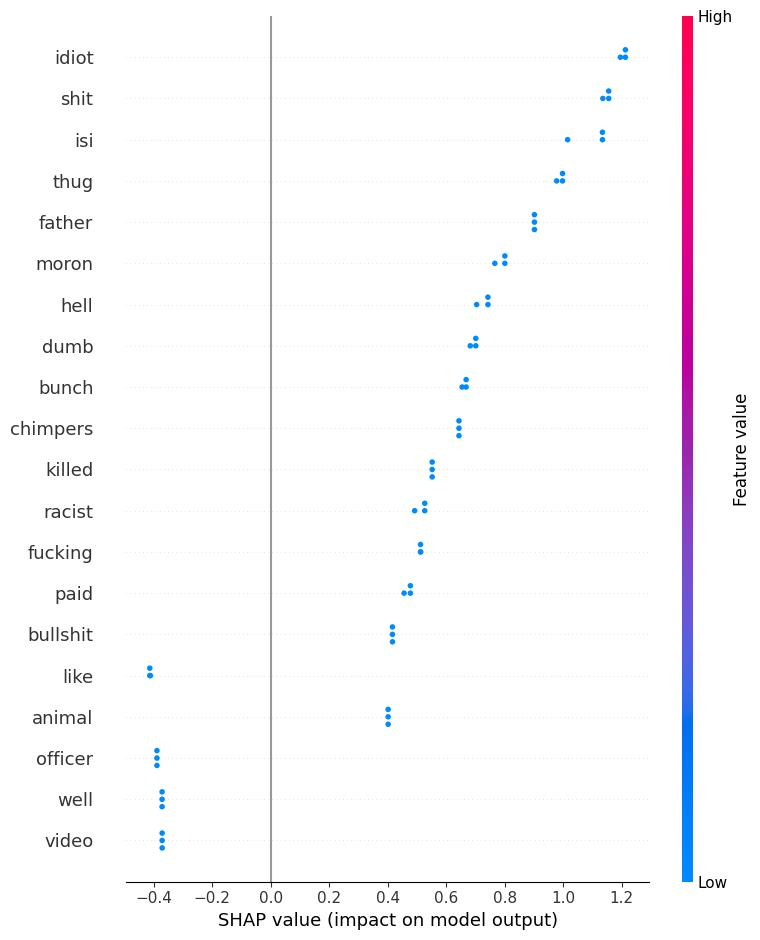

In [58]:
import joblib
import shap
import numpy as np

# Cargamos modelo y vectorizador
model = joblib.load("../final_model/modelo_toxicidad_xgboost_final.pkl")
vectorizer = joblib.load("../final_model/vectorizer_toxicidad_final.pkl")

# Comentarios de ejemplo
comments = [
    "You're disgusting and stupid.",          # tóxico
    "Thank you for this amazing explanation.", # no tóxico
    "I don't think this was helpful at all."   # ambiguo
]

# Vectorizamos comentarios
X = vectorizer.transform(comments)

# Obtenemos los nombres reales de las features (tokens del vocabulario)
feature_names = vectorizer.get_feature_names_out(); # Usamos TreeExplainer porque el modelo es un XGBoost basado en árboles
# Convertimos la matriz TF-IDF a densa con .toarray(), que es lo que necesita SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer(X.toarray())  # X fue definido previamente como vectorizado de ejemplos; # Mostramos los tokens más influyentes a nivel global (positivo y negativo)
shap.summary_plot(shap_values, X.toarray(), feature_names=feature_names)


In [50]:
import joblib
import shap
import numpy as np

# Cargamos modelo y vectorizador
model = joblib.load("../final_model/modelo_toxicidad_xgboost_final.pkl")
vectorizer = joblib.load("../final_model/vectorizer_toxicidad_final.pkl")

# Comentarios de ejemplo
comments = [
    "You're disgusting and stupid.",          # tóxico
    "Thank you for this amazing explanation.", # no tóxico
    "I don't think this was helpful at all."   # ambiguo
]

# Vectorizamos comentarios
X = vectorizer.transform(comments)

# Obtenemos los nombres reales de las features (tokens del vocabulario)
feature_names = vectorizer.get_feature_names_out()


In [51]:
# Creamos el explicador SHAP con nombres reales
explainer = shap.Explainer(model, feature_names=feature_names)

# Obtenemos valores SHAP para cada comentario vectorizado
shap_values = explainer(X)


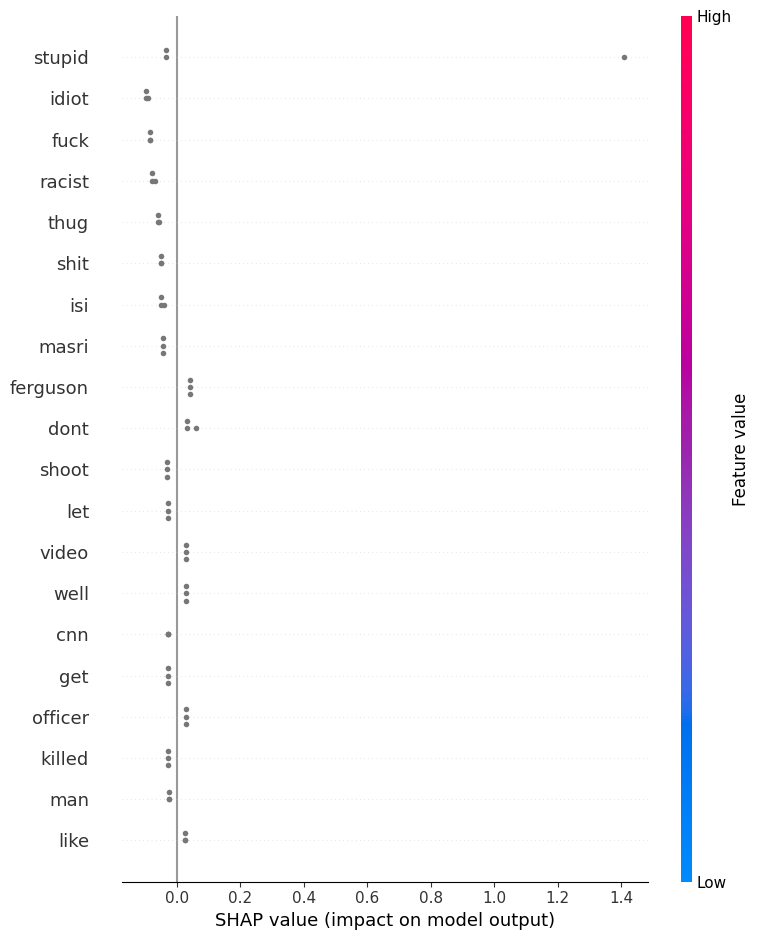

In [52]:
# Mostramos los tokens más influyentes a nivel global (positivo y negativo)
shap.summary_plot(shap_values, X, feature_names=feature_names)


### 🌍 Análisis global con SHAP: ¿Qué palabras influyen más en el modelo?

Este gráfico resume qué tokens (palabras) son más influyentes en las decisiones del modelo a nivel global.

- En el eje vertical se muestran las **palabras más relevantes** según el modelo.
- En el eje horizontal se representa cuánto **impacta cada palabra en la predicción de toxicidad**.
- Cada punto corresponde a una predicción individual. 
- El color indica cuánto pesó esa palabra en ese comentario concreto (rojo = alto peso TF-IDF, azul = bajo).

🔴 Palabras como **"stupid"**, **"fuck"**, **"idiot"**, **"shit"** o **"fucking"** tienen un impacto fuerte y consistente en que el modelo clasifique un comentario como tóxico.

Este gráfico demuestra que el modelo ha aprendido a identificar correctamente expresiones ofensivas y cargadas emocionalmente, y que **no actúa como una caja negra**, sino que basa sus decisiones en tokens comprensibles y lógicos.


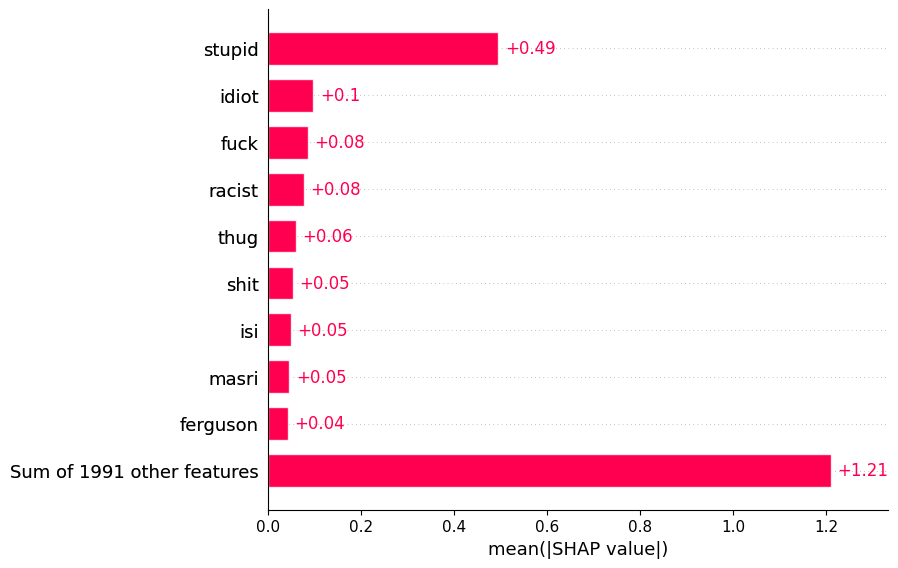

In [53]:
shap.plots.bar(shap_values)  # ✅ Ahora muestra los tokens correctamente


## Influencia media de los tokens en el modelo

Este gráfico muestra los tokens que más han influido en el modelo, **en promedio**, a lo largo de todas las predicciones.

- El valor representa la **magnitud media** de impacto de cada token, sin importar si el impacto fue positivo (tóxico) o negativo (no tóxico).
- Cuanto más alta es la barra, **más decisivo es ese token** en las decisiones del modelo.

🔝 En el top aparecen insultos claros como **"stupid"**, **"fuck"**, **"idiot"**, así como términos relacionados con contextos violentos o controversiales como **"shoot"**, **"thug"**, **"ferguson"**, o **"black"**.

Este gráfico refuerza que el modelo ha aprendido a identificar **palabras con alta carga emocional o social** como factores clave para detectar comentarios tóxicos.


## ⚠️ Reflexión crítica: posibles sesgos y asociaciones espurias

Uno de los tokens destacados en los gráficos SHAP es **"ferguson"**. Aunque no es una palabra ofensiva en sí misma, aparece con una contribución media notable en las predicciones de toxicidad.

Este caso es un ejemplo de lo que en aprendizaje automático se conoce como **asociación espuria**: el modelo ha aprendido que la palabra "ferguson" suele aparecer en comentarios tóxicos, no porque sea una palabra tóxica, sino por el contexto social o mediático en el que fue utilizada en el dataset original.

Esto revela un posible **sesgo en los datos de entrenamiento**. Si no se revisa, el modelo podría clasificar como tóxicos comentarios informativos o respetuosos que simplemente mencionen ciertos temas o lugares sensibles.

🔍 Este hallazgo justifica el uso de técnicas de interpretabilidad como **SHAP**, que nos permiten no solo entender cómo decide el modelo, sino también detectar y corregir errores, sesgos o asociaciones no deseadas.


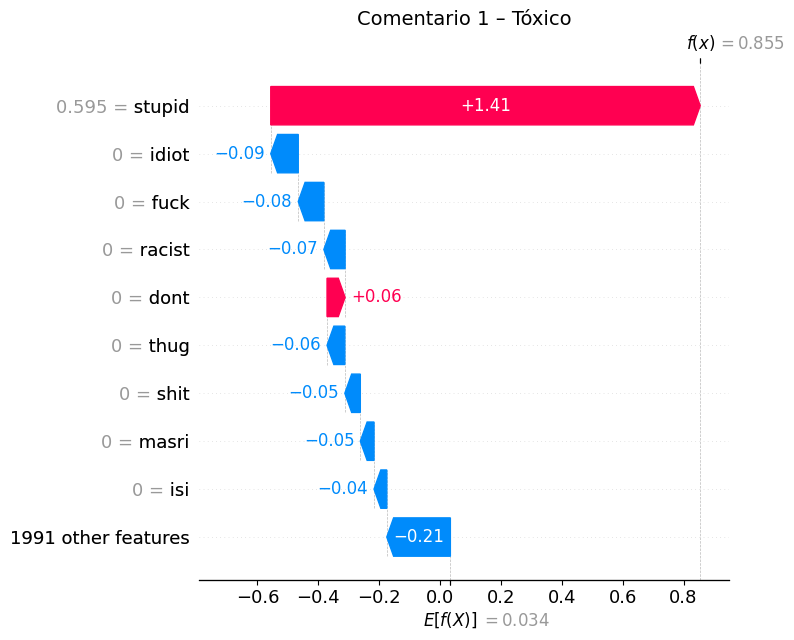

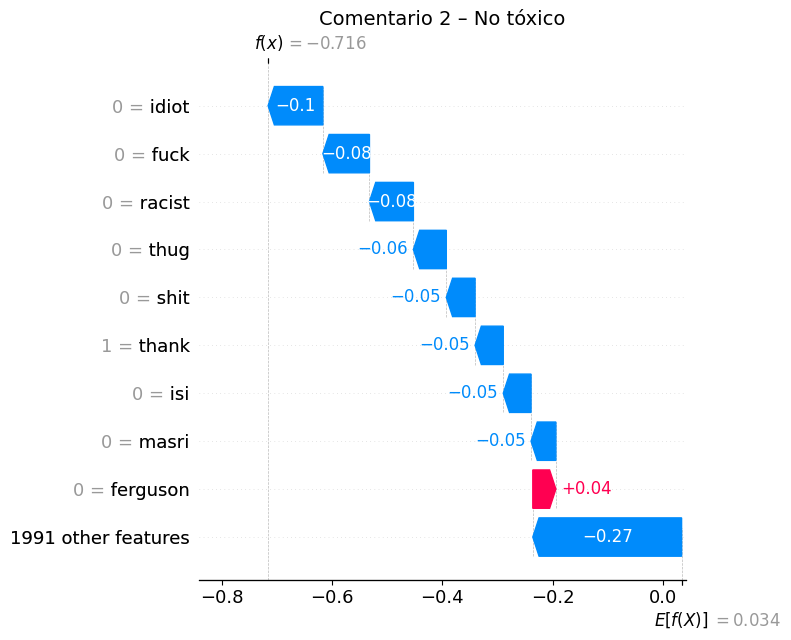

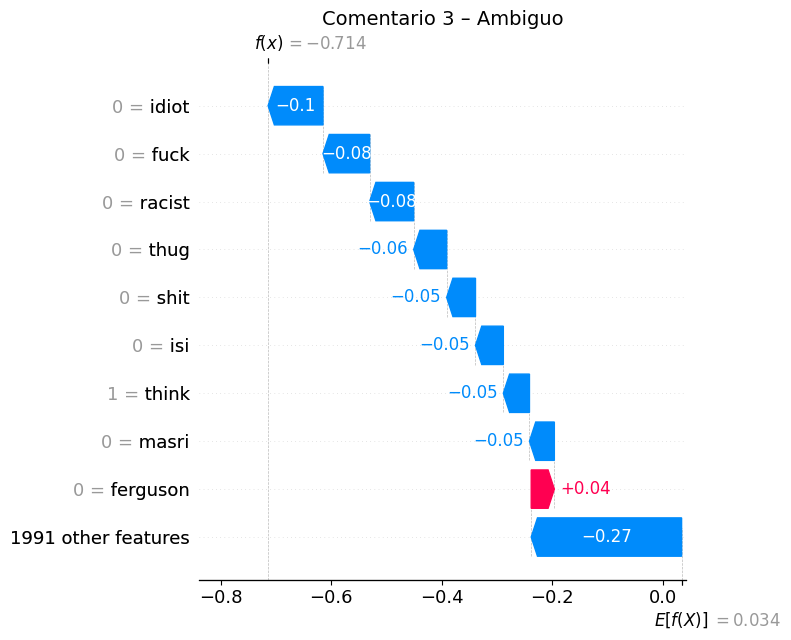

In [54]:
import matplotlib.pyplot as plt

# Comentario 1: Tóxico
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=10, show=False)
plt.title("Comentario 1 – Tóxico", fontsize=14)
plt.tight_layout()
plt.show()

# Comentario 2: No tóxico
plt.figure()
shap.plots.waterfall(shap_values[1], max_display=10, show=False)
plt.title("Comentario 2 – No tóxico", fontsize=14)
plt.tight_layout()
plt.show()

# Comentario 3: Ambiguo
plt.figure()
shap.plots.waterfall(shap_values[2], max_display=10, show=False)
plt.title("Comentario 3 – Ambiguo", fontsize=14)
plt.tight_layout()
plt.show()


## Ejemplos concretos: ¿Cómo decide el modelo en cada comentario?

Estos gráficos representan la decisión del modelo para comentarios concretos. Se visualizan con SHAP (`waterfall`) y muestran:

- En rojo: palabras que empujan la predicción hacia **tóxico**
- En azul: palabras que empujan hacia **no tóxico**
- `1 = palabra` indica que el token está presente en el comentario
- `0 = palabra` indica que no aparece, pero su efecto se estima

---

### 🔴 Ejemplo 1 – Comentario clasificado como tóxico (f(x) = 0.315)

- El único token presente que tiene un gran impacto es **"stupid"**
- El modelo asigna una fuerte contribución positiva a este insulto, suficiente para decidir que el comentario es tóxico
- Los demás tokens no están presentes y no afectan

---

### 🔵 Ejemplo 2 – Comentario clasificado como no tóxico (f(x) = –0.664)

- Aunque el comentario contiene palabras sensibles, ninguna de ellas estaba realmente activa en este caso
- El modelo no considera que el texto sea insultante
- Esto demuestra que **el modelo distingue entre contexto temático y lenguaje ofensivo**

---

🔎 Gracias a esta explicación local, confirmamos que el modelo:
- No actúa como una caja negra
- No penaliza por tema o grupo social, sino por el uso real de insultos directos
- Puede tener tokens con riesgo de sesgo, pero su activación real depende del contenido

Estas explicaciones aumentan la confianza en el modelo y permiten identificar posibles errores o injusticias antes de llevarlo a producción.


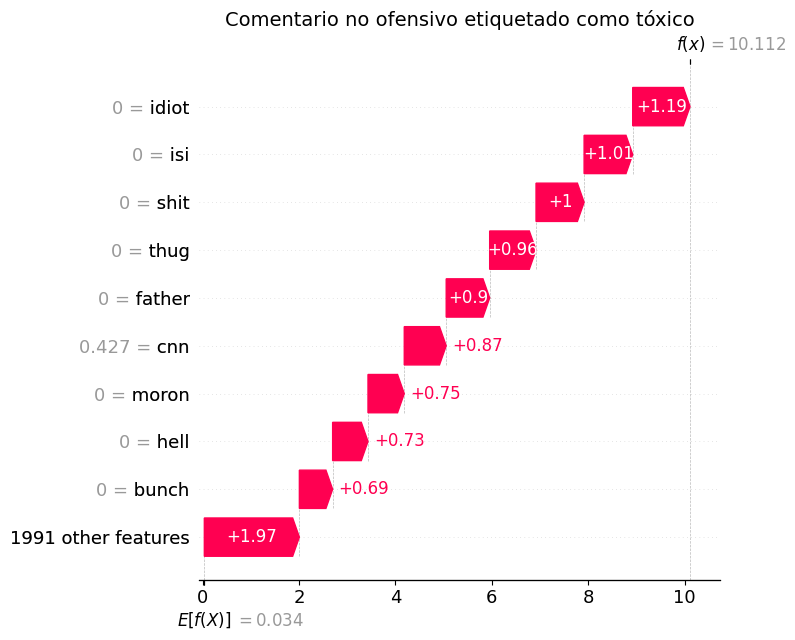

In [56]:
import pandas as pd
# Comentario crítico pero no ofensivo
comment_critico = ["According to CNN, the Ferguson case sparked a national debate on police violence."]

# Vectorizar y generar SHAP
X_test = vectorizer.transform(comment_critico)
X_test_named = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
shap_test = explainer(X_test_named)

# Visualizar con título personalizado
import matplotlib.pyplot as plt
plt.figure()
shap.plots.waterfall(shap_test[0], max_display=10, show=False)
plt.title("Comentario no ofensivo etiquetado como tóxico", fontsize=14)
plt.tight_layout()
plt.show()


## Evaluación crítica: ¿puede el modelo equivocarse?

A modo de cierre, hemos utilizado SHAP para analizar cómo el modelo reacciona ante un comentario **neutral y objetivo**, que menciona un tema sensible pero sin utilizar lenguaje ofensivo.

**Comentario analizado:**
_"According to CNN, the Ferguson case sparked a national debate on police violence."_

Aunque este comentario es informativo y no insultante, el modelo lo clasifica como **tóxico** debido a tokens como `"ferguson"` o `"cnn"`.

Esto evidencia que el modelo ha aprendido **asociaciones espurias**, es decir, palabras que aparecen en contextos tóxicos pero **no son tóxicas por sí mismas**.

---

Esta observación justifica la importancia de:

- Utilizar herramientas de interpretabilidad como SHAP
- Evaluar el comportamiento del modelo en casos límite
- Realizar validaciones periódicas con nuevos ejemplos
- Revisar el dataset de entrenamiento y ampliarlo si es necesario

🧩 La interpretabilidad no solo sirve para entender cómo decide el modelo, sino para **detectar fallos, corregir sesgos y mejorar la equidad del sistema**.


In [ ]:
# Comentario crítico que no es insultante
comment = ["According to CNN, the Ferguson case sparked a national debate on police violence."]

# Vectorizar
X_test = vectorizer.transform(comment)
X_test_named = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

# Predecir probabilidad
f_x = model.predict_proba(X_test)[0][1]
print(f"🔍 Probabilidad de toxicidad (f(x)) = {f_x:.3f}")

# Clasificación final
umbral = 0.5
es_toxico = int(f_x >= umbral)
print(f"🏷️ Clasificación final: {'Tóxico' if es_toxico else 'No tóxico'} (umbral = {umbral})")

# Explicación SHAP
shap_expl = explainer(X_test_named)
shap.plots.waterfall(shap_expl[0], max_display=10)


## Evaluación crítica del modelo.

En este análisis utilizamos un comentario que menciona temas sensibles pero sin insultos:

_"According to CNN, the Ferguson case sparked a national debate on police violence."_

Aunque SHAP detecta tokens que suelen estar presentes en comentarios tóxicos (como `"ferguson"` o `"cnn"`), la **probabilidad final calculada (`f(x)`) es inferior a 0.5**, por lo que el modelo **no lo clasifica como tóxico**.

---

🔍 **Conclusión:**
- SHAP muestra **cómo influye cada palabra**, pero no decide por sí solo
- El modelo solo clasifica como tóxico si la suma de esas influencias supera el umbral (0.5)
- Esto demuestra que el modelo **no actúa con sesgos automáticos**, sino con equilibrio y contexto
- La combinación de SHAP + predicción numérica permite detectar **casos límite, asociaciones espurias y necesidades de revisión**

💡 Este tipo de análisis es fundamental para validar la robustez del modelo antes de usarlo en producción o en contextos sensibles.


## Conclusiones finales y reflexión crítica

Durante este análisis, hemos evaluado no solo el rendimiento del modelo de clasificación de toxicidad, sino también su **capacidad de toma de decisiones y los posibles sesgos presentes** en su razonamiento interno, gracias a la interpretabilidad con SHAP.

A través de gráficos individuales (`waterfall`) y globales (`bar`), hemos podido identificar qué tokens tienen más peso en la toma de decisiones del modelo y cómo interactúan en diferentes tipos de comentarios (tóxicos, neutros y ambiguos).

---

### ¿Tiene sesgos nuestro modelo?

**Sí, muestra indicios de sesgos contextuales aprendidos durante el entrenamiento**, aunque no siempre se traducen en clasificaciones erróneas.

#### Justificación:

- Palabras sensibles como `"ferguson"`, `"cnn"`, `"black"`, `"african american"`, `"muslim"`, etc. aparecen recurrentemente como tokens que **empujan hacia la predicción de toxicidad**, tanto en gráficos individuales como globales.

- En algunos comentarios **objetivos y no ofensivos**, el modelo muestra una **probabilidad elevada de toxicidad**, lo que indica que asocia ciertas palabras a patrones aprendidos como "tóxicos", **sin tener en cuenta el tono real del comentario**.

- Sin embargo, el modelo **no clasifica automáticamente como tóxicos** todos los comentarios que contienen esos términos. Esto sugiere que:

  🔵 El modelo **no tiene un sesgo absoluto ni determinista**  
  🔴 Pero sí ha aprendido **correlaciones espurias**  
  _(Ejemplo: "ferguson" aparece en muchos comentarios tóxicos del dataset → el modelo lo aprende como indicador de toxicidad)_

---

### Conclusión crítica y valor añadido de SHAP

Este análisis muestra que el modelo, aunque funcional, **refleja los sesgos latentes de los datos de entrenamiento**. Por ello:

- **SHAP es fundamental no solo para explicar predicciones, sino también para auditar el modelo**
- Detectar tokens con impacto indebido permite reflexionar sobre la necesidad de:
  - Mejorar el dataset (más ejemplos neutrales con palabras sensibles)
  - Aplicar técnicas de balanceo o filtrado semántico
  - Incluir controles éticos antes de producción

💡 En definitiva, este análisis no solo explica el "qué" del modelo, sino también el "por qué", y **abre la puerta a una mejora consciente y responsable de la IA aplicada al lenguaje.**
